In [1]:
import pandas as pd
import numpy as np
from math import floor
from scipy.stats import loguniform
import warnings
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
#import shap

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, roc_auc_score

# Data Analysis/Preprocessing

In [2]:
raw_data = pd.read_csv('df_new_features(3).csv')
raw_data = raw_data.drop('Unnamed: 0',axis = 1)
raw_data.head()

,SeasonID,TeamID,Conference,PlayoffRankLag1,WinPCTLag1,DiffPointsPGLag1,DivisionRankLag1,LongHomeStreakLag1,LongRoadStreakLag1,LongWinStreakLag1,...,ConferenceGamesBackLag4,DivisionGamesBackLag4,ClinchedConferenceTitleLag4,ClinchedDivisionTitleLag4,EliminatedConferenceLag4,EliminatedDivisionLag4,isPlayoff,nyt_score,twitter_score,reddit_score
0,2008,1610612739,East,4,0.549,-0.4,2,9,1,5,...,17.0,12.0,0,0,0,0,1,0.038036,0.024716,0.223679
1,2008,1610612747,West,1,0.695,7.3,1,6,7,10,...,28.0,28.0,1,0,0,0,1,0.235119,0.070399,0.063052
2,2008,1610612743,West,8,0.610,3.7,2,9,3,6,...,13.0,3.0,0,0,0,0,1,0.098203,-0.037116,0.013385
3,2008,1610612738,East,1,0.805,10.3,1,12,10,10,...,14.0,0.0,0,1,0,0,1,-0.014583,0.095421,0.112292
4,2008,1610612759,West,3,0.683,4.8,2,13,5,11,...,3.0,0.0,0,1,0,0,1,0.086667,0.097475,0.065091


In [3]:
add_stats = pd.read_csv('nba_add_stats.csv')
add_stats = add_stats.drop('Unnamed: 0',axis = 1)

In [4]:
raw_data_new = raw_data.merge(add_stats, how='inner', left_on=['TeamID', 'SeasonID'], 
               right_on=['TEAM_ID', 'YEAR']).drop(['TEAM_ID','YEAR'],axis=1)

In [5]:
raw_data_new.head()

,SeasonID,TeamID,Conference,PlayoffRankLag1,WinPCTLag1,DiffPointsPGLag1,DivisionRankLag1,LongHomeStreakLag1,LongRoadStreakLag1,LongWinStreakLag1,...,isPlayoff,nyt_score,twitter_score,reddit_score,REB,AST,PF,STL,TOV,BLK
0,2008,1610612739,East,4,0.549,-0.4,2,9,1,5,...,1,0.038036,0.024716,0.223679,3460,1663,1663,593,1045,435
1,2008,1610612747,West,1,0.695,7.3,1,6,7,10,...,1,0.235119,0.070399,0.063052,3602,1908,1698,718,1103,420
2,2008,1610612743,West,8,0.610,3.7,2,9,3,6,...,1,0.098203,-0.037116,0.013385,3412,1820,1874,710,1257,492
3,2008,1610612738,East,1,0.805,10.3,1,12,10,10,...,1,-0.014583,0.095421,0.112292,3455,1862,1897,621,1280,387
4,2008,1610612759,West,3,0.683,4.8,2,13,5,11,...,1,0.086667,0.097475,0.065091,3366,1736,1546,474,963,329


In [6]:
train_data = raw_data_new.iloc[:-60]
validation_data = raw_data_new.iloc[-60:-30]
test_data = raw_data_new.iloc[-30:]

In [7]:
# Split into X and y train
X_train = train_data.drop(['SeasonID','TeamID','isPlayoff'],axis = 1)
y_train = train_data['isPlayoff']

X_val = validation_data.drop(['SeasonID','TeamID','isPlayoff'],axis = 1)
y_val = validation_data['isPlayoff']
X_val = X_val.reset_index().drop('index',axis = 1)
y_val = y_val.reset_index().drop('index',axis = 1)

X_test = test_data.drop(['SeasonID','TeamID','isPlayoff'],axis = 1)
y_test = test_data['isPlayoff']
X_test = X_test.reset_index().drop('index',axis = 1)
y_test = y_test.reset_index().drop('index',axis = 1)

In [8]:
len(X_train), len(y_train) ,len(X_val), len(y_val), len(X_test), len(y_test)

(390, 390, 30, 30, 30, 30)

## Standardize Features

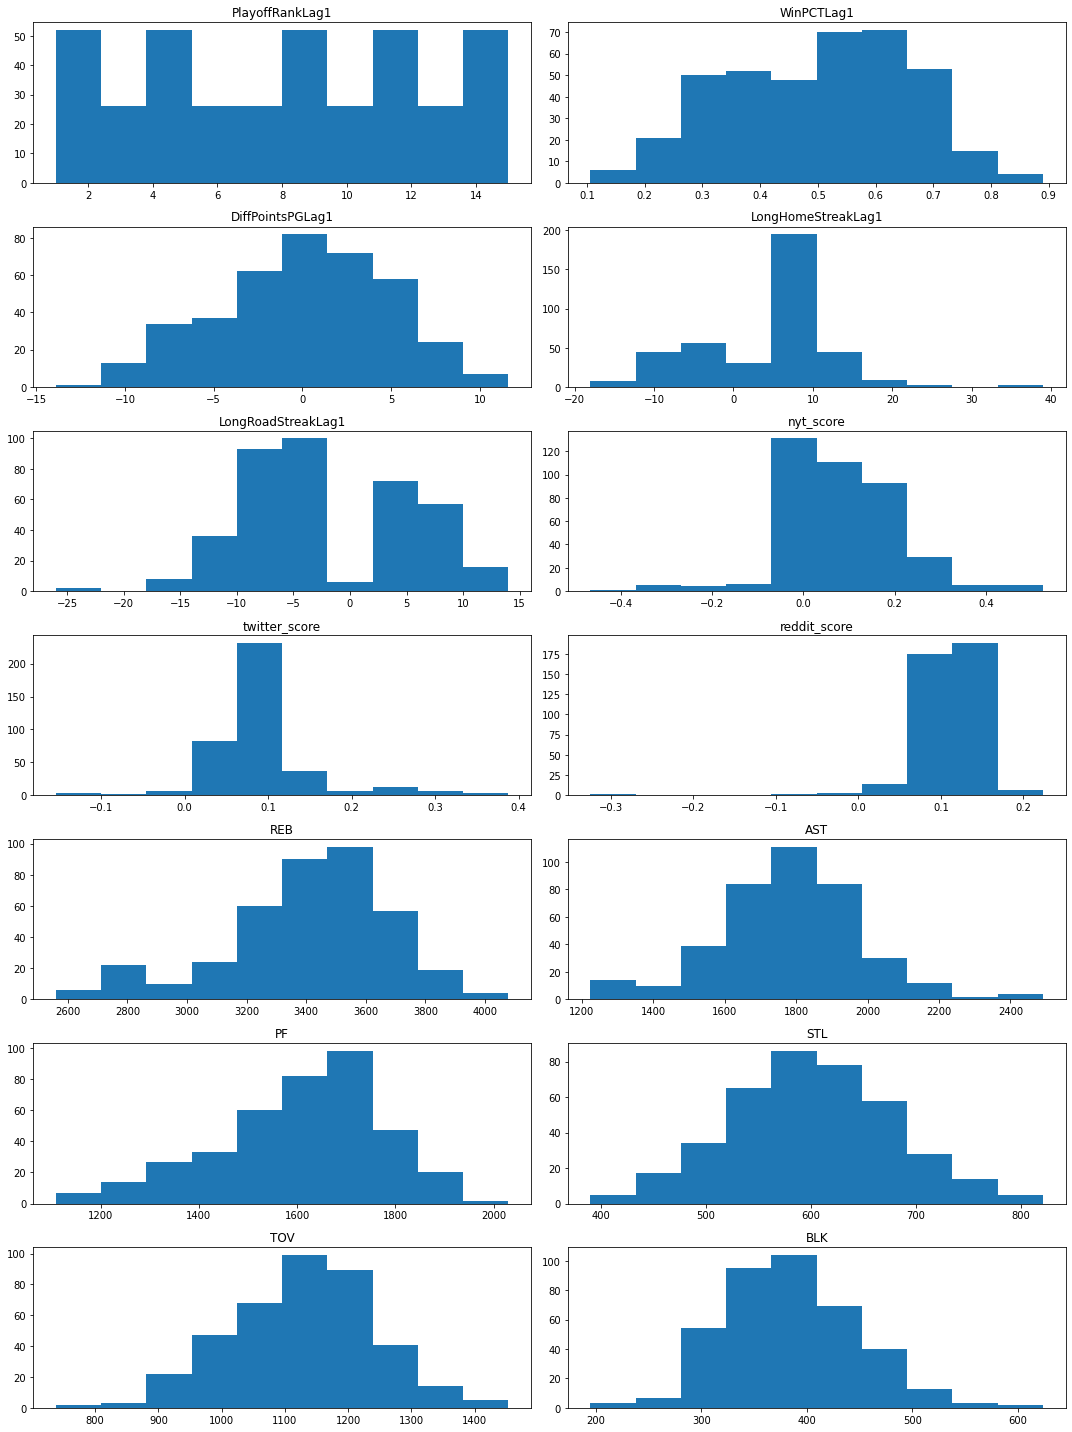

In [9]:
# Analyze numerical data to check for outliers 
fig, axs = plt.subplots(7, 2, figsize=(15, 20))

axs[0,0].hist(X_train['PlayoffRankLag1'])
axs[0,0].set_title('PlayoffRankLag1')

axs[0,1].hist(X_train['WinPCTLag1'])
axs[0,1].set_title('WinPCTLag1')

axs[1,0].hist(X_train['DiffPointsPGLag1'])
axs[1,0].set_title('DiffPointsPGLag1')

axs[1,1].hist(X_train['LongHomeStreakLag1'])
axs[1,1].set_title('LongHomeStreakLag1')

axs[2,0].hist(X_train['LongRoadStreakLag1'])
axs[2,0].set_title('LongRoadStreakLag1')

axs[2,1].hist(X_train['nyt_score'])
axs[2,1].set_title('nyt_score')

axs[3,0].hist(X_train['twitter_score'])
axs[3,0].set_title('twitter_score')

axs[3,1].hist(X_train['reddit_score'])
axs[3,1].set_title('reddit_score')

axs[4,0].hist(X_train['REB'])
axs[4,0].set_title('REB')

axs[4,1].hist(X_train['AST'])
axs[4,1].set_title('AST')

axs[5,0].hist(X_train['PF'])
axs[5,0].set_title('PF')

axs[5,1].hist(X_train['STL'])
axs[5,1].set_title('STL')

axs[6,0].hist(X_train['TOV'])
axs[6,0].set_title('TOV')

axs[6,1].hist(X_train['BLK'])
axs[6,1].set_title('BLK')

plt.tight_layout()
plt.show()

In [10]:
features = X_train.columns.tolist()
features.remove('Conference')

In [11]:
scaler = RobustScaler()

# Train
train_scaled_data = pd.DataFrame(scaler.fit_transform(X_train[features]),columns = features)
X_train = train_scaled_data.join(X_train.drop(features, axis = 1))
X_train.head()

,PlayoffRankLag1,WinPCTLag1,DiffPointsPGLag1,DivisionRankLag1,LongHomeStreakLag1,LongRoadStreakLag1,LongWinStreakLag1,LongLossStreakLag1,ConferenceGamesBackLag1,DivisionGamesBackLag1,...,nyt_score,twitter_score,reddit_score,REB,AST,PF,STL,TOV,BLK,Conference
0,-0.500,0.158969,-0.088561,-0.5,0.235294,0.461538,0.000000,0.25,0.091954,0.043478,...,-0.284424,-1.651405,4.927180,0.037647,-0.486772,0.124559,-0.057143,-0.609836,0.632530,East
1,-0.875,0.786251,1.047970,-1.0,0.000000,0.923077,1.666667,-0.50,-0.873563,-0.565217,...,1.000413,-0.314321,-2.292602,0.483137,0.550265,0.289072,1.133333,-0.229508,0.451807,West
2,0.000,0.421053,0.516605,-0.5,0.235294,0.615385,0.333333,-0.50,-0.551724,-0.391304,...,0.107820,-3.461149,-4.524965,-0.112941,0.177778,1.116334,1.057143,0.780328,1.319277,West
3,-0.875,1.258861,1.490775,-1.0,0.470588,1.153846,1.666667,-0.50,-0.873563,-0.565217,...,-0.627461,0.418021,-0.079368,0.021961,0.355556,1.224442,0.209524,0.931148,0.054217,East
4,-0.625,0.734694,0.678967,-0.5,0.549020,0.769231,2.000000,-0.25,-0.827586,-0.565217,...,0.032614,0.478145,-2.200954,-0.257255,-0.177778,-0.425382,-1.190476,-1.147541,-0.644578,West


In [12]:
# Validation
val_scaled_data = pd.DataFrame(scaler.transform(X_val[features]),columns = features)
X_val = val_scaled_data.join(X_val.drop(features, axis = 1))
X_val.head()

,PlayoffRankLag1,WinPCTLag1,DiffPointsPGLag1,DivisionRankLag1,LongHomeStreakLag1,LongRoadStreakLag1,LongWinStreakLag1,LongLossStreakLag1,ConferenceGamesBackLag1,DivisionGamesBackLag1,...,nyt_score,twitter_score,reddit_score,REB,AST,PF,STL,TOV,BLK,Conference
0,-0.250,0.189044,-0.029520,-0.5,-0.078431,0.846154,0.333333,0.25,-0.459770,-0.521739,...,0.402659,0.826296,0.555811,0.429804,1.320635,0.199765,0.066667,0.367213,-1.415663,East
1,-0.750,0.842105,0.826568,-1.0,0.313725,0.923077,0.666667,-0.50,-0.827586,-0.565217,...,0.155756,0.461668,0.859274,0.834510,1.972487,-0.016451,0.980952,-0.511475,-0.283133,West
2,-0.125,-0.051557,0.191882,0.5,-0.078431,-0.153846,0.333333,-0.25,-0.275862,0.000000,...,-0.532388,0.520432,0.193360,1.035294,1.092063,-0.542891,-0.076190,-0.131148,1.150602,East
3,0.000,0.068743,0.118081,-0.5,-0.862745,0.769231,0.666667,-0.25,-0.229885,-0.391304,...,-0.532388,-0.556379,0.746614,1.832157,1.494180,-0.077556,1.914286,-0.367213,1.813253,West
4,0.125,0.128894,0.132841,0.5,0.000000,0.000000,0.333333,-0.25,-0.275862,-0.043478,...,0.895640,4.224741,1.025366,0.884706,1.883598,0.406580,1.142857,0.544262,-0.126506,West


In [13]:
# Test
test_scaled_data = pd.DataFrame(scaler.transform(X_test[features]),columns = features)
X_test = test_scaled_data.join(X_test.drop(features, axis = 1))
X_test.head()

,PlayoffRankLag1,WinPCTLag1,DiffPointsPGLag1,DivisionRankLag1,LongHomeStreakLag1,LongRoadStreakLag1,LongWinStreakLag1,LongLossStreakLag1,ConferenceGamesBackLag1,DivisionGamesBackLag1,...,nyt_score,twitter_score,reddit_score,REB,AST,PF,STL,TOV,BLK,Conference
0,-0.250,0.313641,0.309963,-0.5,0.000000,0.923077,0.333333,0.25,-0.137931,-0.521739,...,-0.532388,0.676313,0.919853,-0.307451,2.044444,-0.862515,-0.142857,-0.085246,-0.487952,West
1,-0.625,0.472610,0.472325,-1.0,0.235294,0.692308,1.000000,-0.50,-0.781609,-0.565217,...,1.423389,0.650488,0.872013,1.113725,0.931217,-1.012926,-0.961905,-0.019672,0.066265,East
2,-0.750,0.472610,1.047970,-1.0,-0.078431,0.923077,1.333333,-0.50,-0.781609,-0.565217,...,0.025217,0.691993,-0.122220,0.244706,1.227513,-0.716804,-0.914286,-0.668852,0.319277,East
3,-0.750,0.734694,0.811808,-1.0,0.313725,0.846154,2.000000,-0.50,-0.505747,-0.565217,...,-0.532388,1.228638,0.675330,0.596078,0.973545,-0.303173,0.466667,-0.472131,0.837349,West
4,0.500,-0.627282,-0.841328,1.0,-0.862745,-0.615385,-0.666667,0.50,0.689655,0.913043,...,-0.532388,0.659809,-0.268302,-0.442353,1.460317,-0.448884,-0.542857,-0.524590,-1.463855,West


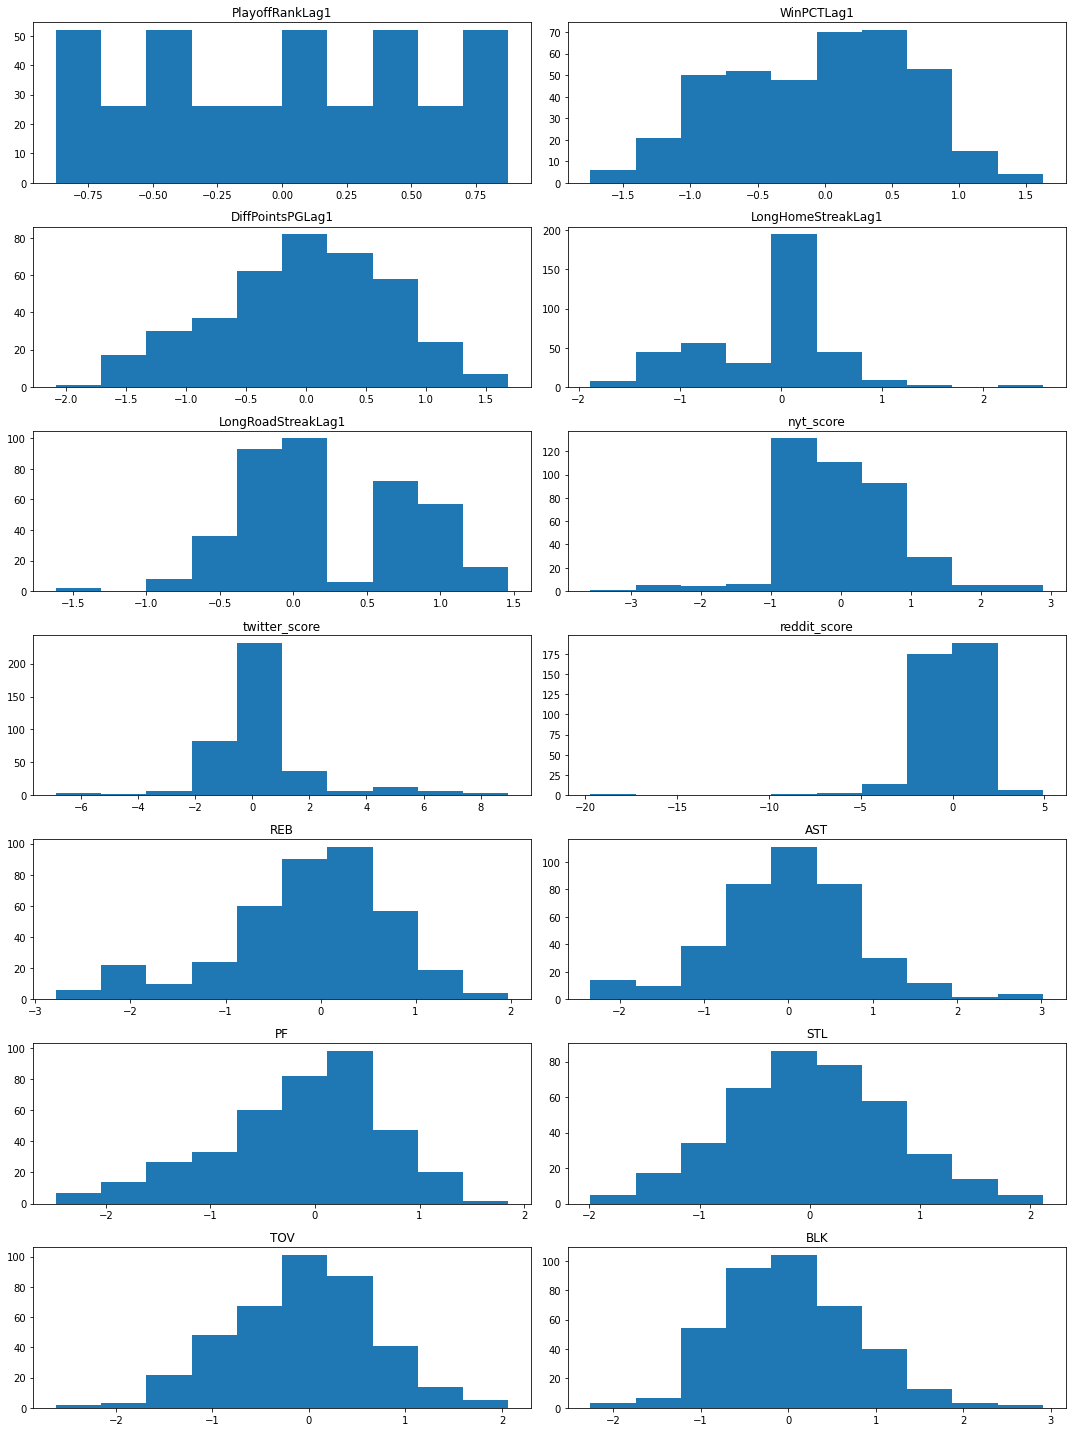

In [14]:
# Analyze numerical data to check for outliers 
fig, axs = plt.subplots(7, 2, figsize=(15, 20))

axs[0,0].hist(X_train['PlayoffRankLag1'])
axs[0,0].set_title('PlayoffRankLag1')

axs[0,1].hist(X_train['WinPCTLag1'])
axs[0,1].set_title('WinPCTLag1')

axs[1,0].hist(X_train['DiffPointsPGLag1'])
axs[1,0].set_title('DiffPointsPGLag1')

axs[1,1].hist(X_train['LongHomeStreakLag1'])
axs[1,1].set_title('LongHomeStreakLag1')

axs[2,0].hist(X_train['LongRoadStreakLag1'])
axs[2,0].set_title('LongRoadStreakLag1')

axs[2,1].hist(X_train['nyt_score'])
axs[2,1].set_title('nyt_score')

axs[3,0].hist(X_train['twitter_score'])
axs[3,0].set_title('twitter_score')

axs[3,1].hist(X_train['reddit_score'])
axs[3,1].set_title('reddit_score')

axs[4,0].hist(X_train['REB'])
axs[4,0].set_title('REB')

axs[4,1].hist(X_train['AST'])
axs[4,1].set_title('AST')

axs[5,0].hist(X_train['PF'])
axs[5,0].set_title('PF')

axs[5,1].hist(X_train['STL'])
axs[5,1].set_title('STL')

axs[6,0].hist(X_train['TOV'])
axs[6,0].set_title('TOV')

axs[6,1].hist(X_train['BLK'])
axs[6,1].set_title('BLK')

plt.tight_layout()
plt.show()

## One Hot Encode

In [15]:
# Train data
ohe = OneHotEncoder()
encoded_data = ohe.fit_transform(X_train[['Conference']]).toarray()
columns = ohe.get_feature_names(X_train[['Conference']].columns)
train_encoded = pd.DataFrame(encoded_data, columns=columns)

X_train = pd.concat([X_train.drop('Conference',axis=1),train_encoded],axis = 1)

In [16]:
# Validation data
encoded_data = ohe.transform(X_val[['Conference']]).toarray()
columns = ohe.get_feature_names(X_val[['Conference']].columns)
val_encoded = pd.DataFrame(encoded_data, columns=columns)

X_val = pd.concat([X_val.drop('Conference',axis=1),val_encoded],axis = 1)

In [17]:
# Test data
encoded_data = ohe.transform(X_test[['Conference']]).toarray()
columns = ohe.get_feature_names(X_test[['Conference']].columns)
test_encoded = pd.DataFrame(encoded_data, columns=columns)

X_test = pd.concat([X_test.drop('Conference',axis=1),test_encoded],axis = 1)

# Building Models (Round 1: Before Feature Selection)

Here we will only run the tree based models first. This is as tree based models are better able to handle large number of features and we can plot the feature importance chart from these models.

In [19]:
# Creating time series split
num_obs = len(train_data)
num_per_season = 30
n_splits = int(num_obs/num_per_season - 1)

time_series_split = TimeSeriesSplit(n_splits = n_splits)

In [20]:
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")

In [22]:
# Scoring metric
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

## AdaBoost

In [24]:
# Hyperparameter tuning
adaboost_param = {'n_estimators': np.arange(50,500,30), 'learning_rate': loguniform(0.01, 0.99)}

# Build the model
adaboost = AdaBoostClassifier()
adaboost_gridsearch = RandomizedSearchCV(adaboost, adaboost_param, n_iter = 150, cv = time_series_split, 
                                        random_state=42,scoring = scoring, refit = 'f1', n_jobs = -1)
adaboost_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', adaboost_gridsearch.best_params_)

Best hyperparameters: {'learning_rate': 0.023227822290590942, 'n_estimators': 380}


In [26]:
metrics = ['f1-score','Accuracy','Recall','Precision','ROC-AUC']

# Fit to validation set data
best_adaboost = adaboost_gridsearch.best_estimator_
adaboost_pred = best_adaboost.predict(X_val)
adaboost_probs = best_adaboost.predict_proba(X_val)[:,1]

adaboost_f1, adaboost_accuracy = f1_score(y_val,adaboost_pred), accuracy_score(y_val,adaboost_pred)
adaboost_recall, adaboost_precision = recall_score(y_val,adaboost_pred), precision_score(y_val,adaboost_pred)
adaboost_auc = roc_auc_score(y_val,adaboost_probs)

adaboost_metrics = pd.DataFrame([adaboost_f1, adaboost_accuracy, adaboost_recall, adaboost_precision, 
                                 adaboost_auc], index = metrics)
adaboost_metrics

,0
f1-score,0.702703
Accuracy,0.633333
Recall,0.812500
Precision,0.619048
ROC-AUC,0.732143


## Gradient Boosting

In [27]:
# Hyperparameter tuning
xgb_param = {'learning_rate': loguniform(0.01, 0.99), 'n_estimators': np.arange(100,800,100), 
             'max_depth': np.arange(2,13,2), 'gamma': loguniform(0.01, 0.99)}

# Build the model
xgb = XGBClassifier()
xgb_gridsearch = RandomizedSearchCV(xgb, xgb_param, n_iter = 150, cv = time_series_split, random_state=42, 
                                    scoring = scoring,refit = 'f1', n_jobs = -1)
xgb_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', xgb_gridsearch.best_params_)

Best hyperparameters: {'gamma': 0.02310344538796132, 'learning_rate': 0.32168129990550093, 'max_depth': 12, 'n_estimators': 600}


In [28]:
# Fit to validation set data
best_xgb = xgb_gridsearch.best_estimator_
xgb_pred = best_xgb.predict(X_val)
xgb_probs = best_xgb.predict_proba(X_val)[:,1]

xgb_f1, xgb_accuracy = f1_score(y_val,xgb_pred), accuracy_score(y_val,xgb_pred)
xgb_recall, xgb_precision = recall_score(y_val,xgb_pred), precision_score(y_val,xgb_pred)
xgb_auc = roc_auc_score(y_val,xgb_probs)

xgb_metrics = pd.DataFrame([xgb_f1, xgb_accuracy, xgb_recall, xgb_precision, 
                                 xgb_auc], index = metrics)
xgb_metrics

,0
f1-score,0.722222
Accuracy,0.666667
Recall,0.812500
Precision,0.650000
ROC-AUC,0.705357


## Random Forest

In [29]:
# Hyperparameter tuning
rf_param = {'n_estimators': np.arange(50,300,50), 'criterion':['gini', 'entropy'],'max_depth': np.arange(2,10,2),
            'min_samples_split': np.arange(10,30,5),'max_features': ['sqrt', 'log2', None]}

# Build the model
rf = RandomForestClassifier()
rf_gridsearch = RandomizedSearchCV(rf, rf_param, n_iter = 150, cv = time_series_split, random_state=42, 
                                   scoring = scoring, refit = 'f1', n_jobs = -1)
rf_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', rf_gridsearch.best_params_)

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 20, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'gini'}


In [30]:
# Fit to validation set data
best_rf = rf_gridsearch.best_estimator_
rf_pred = best_rf.predict(X_val)
rf_probs = best_rf.predict_proba(X_val)[:,1]

rf_f1, rf_accuracy = f1_score(y_val,rf_pred), accuracy_score(y_val,rf_pred)
rf_recall, rf_precision = recall_score(y_val,rf_pred), precision_score(y_val,rf_pred)
rf_auc = roc_auc_score(y_val,rf_probs)

rf_metrics = pd.DataFrame([rf_f1, rf_accuracy, rf_recall, rf_precision, 
                                 rf_auc], index = metrics)
rf_metrics

,0
f1-score,0.647059
Accuracy,0.600000
Recall,0.687500
Precision,0.611111
ROC-AUC,0.705357


## Summary of Models' Performance

In [31]:
combined_metrics_trees = pd.concat([adaboost_metrics, xgb_metrics,rf_metrics], axis = 1)
combined_metrics_trees.columns = ['AdaBoost','Extreme Gradient Boosting','Random Forest']
combined_metrics_trees

,AdaBoost,Extreme Gradient Boosting,Random Forest
f1-score,0.702703,0.722222,0.647059
Accuracy,0.633333,0.666667,0.600000
Recall,0.812500,0.812500,0.687500
Precision,0.619048,0.650000,0.611111
ROC-AUC,0.732143,0.705357,0.705357


# Model Evaluation (Round 1: Before Feature Selection)

## Correlation Matrix

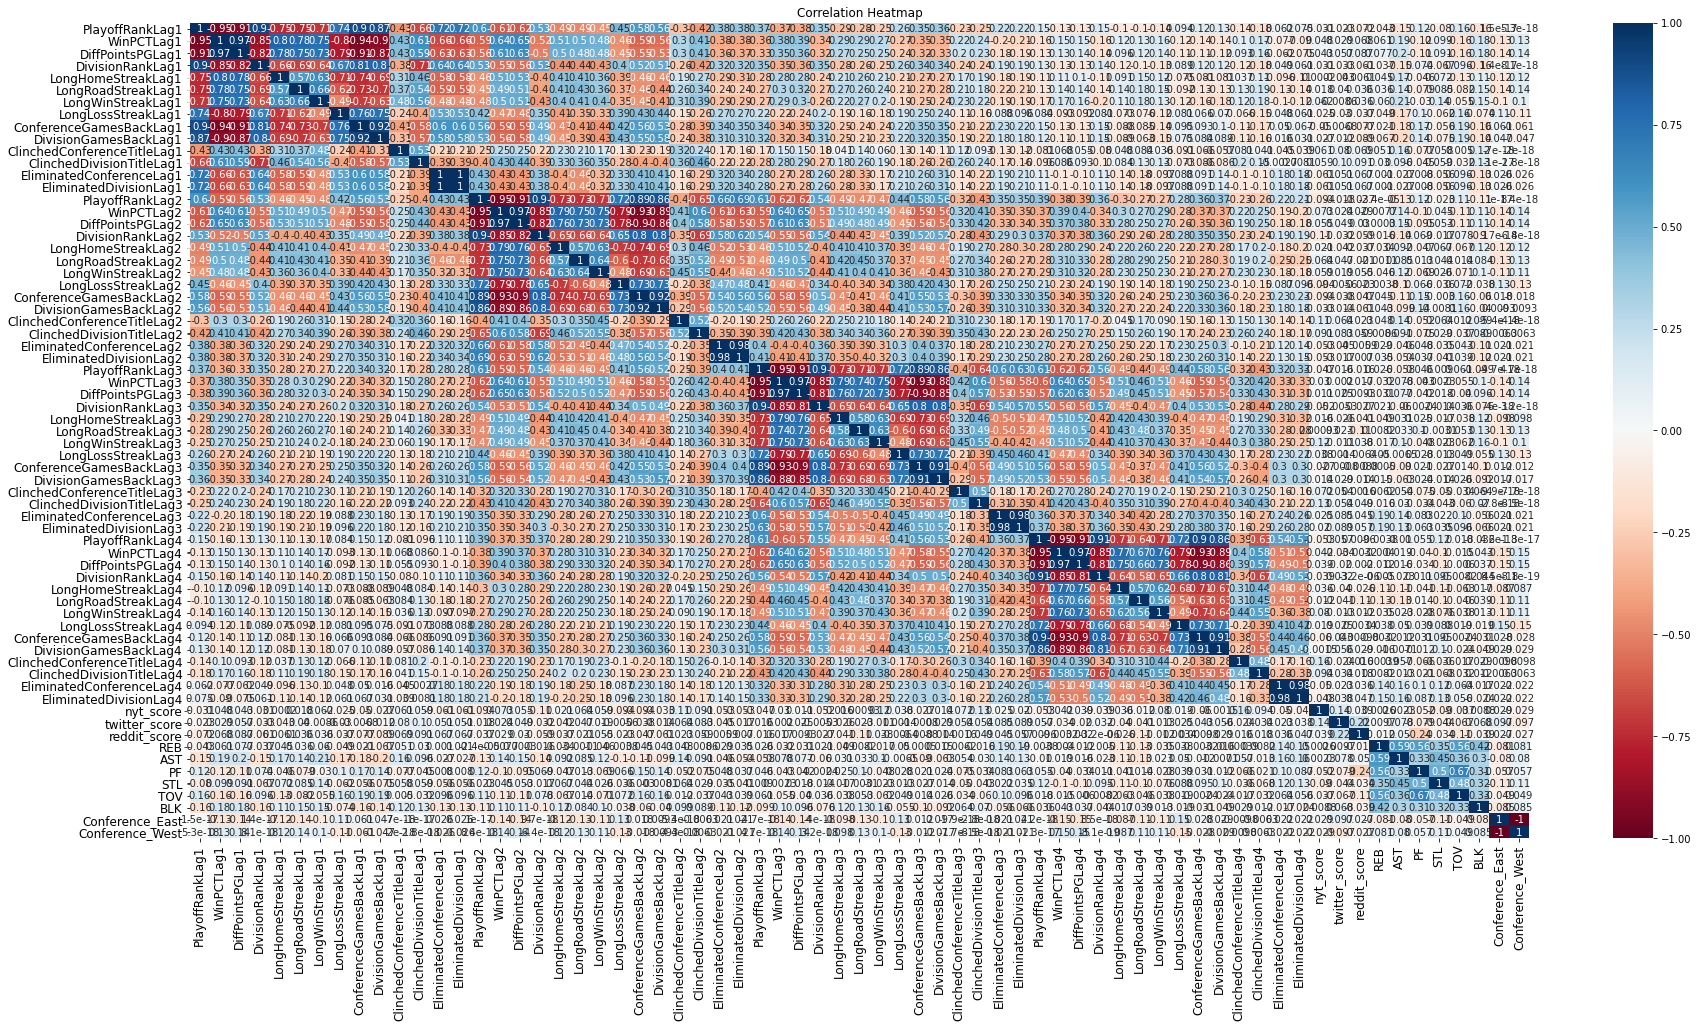

In [35]:
plt.figure(figsize = (30,15))
s = sns.heatmap(X_train.corr(),
             annot = True,
             cmap = 'RdBu',
             vmin = -1,
             vmax= 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

## Feature Importance from Tree Models

Text(0, 0.5, 'FEATURE NAMES')

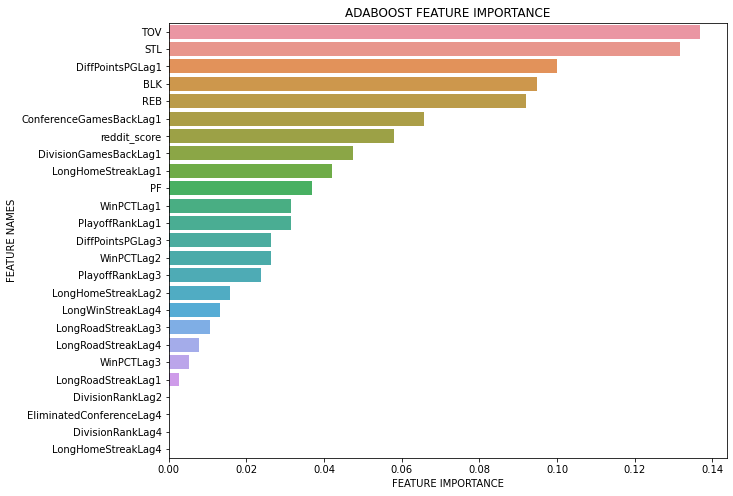

In [45]:
# Adaboost
adaboost_importance = pd.DataFrame(zip(X_train.columns, best_adaboost.feature_importances_), 
                                   columns=['Feature', 'Importance'])
adaboost_importance = adaboost_importance.sort_values('Importance', ascending=False)
adaboost_importance_top20 = adaboost_importance.iloc[:25,:]

plt.figure(figsize=(10,8))
sns.barplot(x=adaboost_importance_top20['Importance'], y=adaboost_importance_top20['Feature'])
plt.title('ADABOOST FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

Text(0, 0.5, 'FEATURE NAMES')

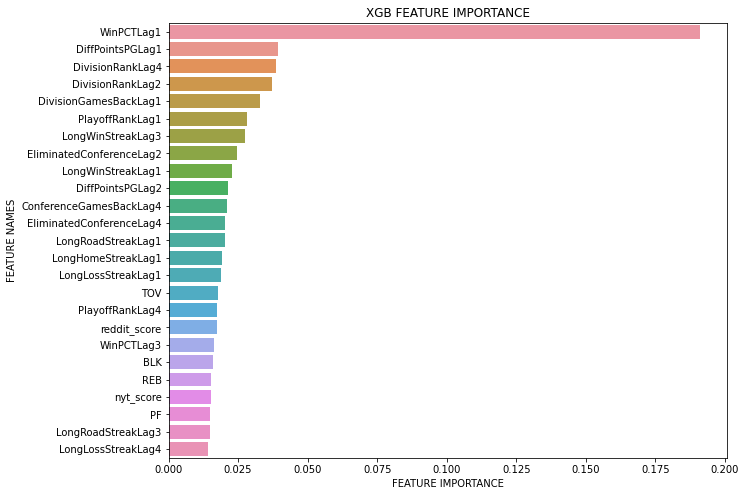

In [43]:
# Extreme Gradient Boost
xgb_importance = pd.DataFrame(zip(X_train.columns, best_xgb.feature_importances_), 
                                   columns=['Feature', 'Importance'])
xgb_importance = xgb_importance.sort_values('Importance', ascending=False)
xgb_importance_top20 = xgb_importance.iloc[:25,:]

plt.figure(figsize=(10,8))
sns.barplot(x=xgb_importance_top20['Importance'], y=xgb_importance_top20['Feature'])
plt.title('XGB FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

Text(0, 0.5, 'FEATURE NAMES')

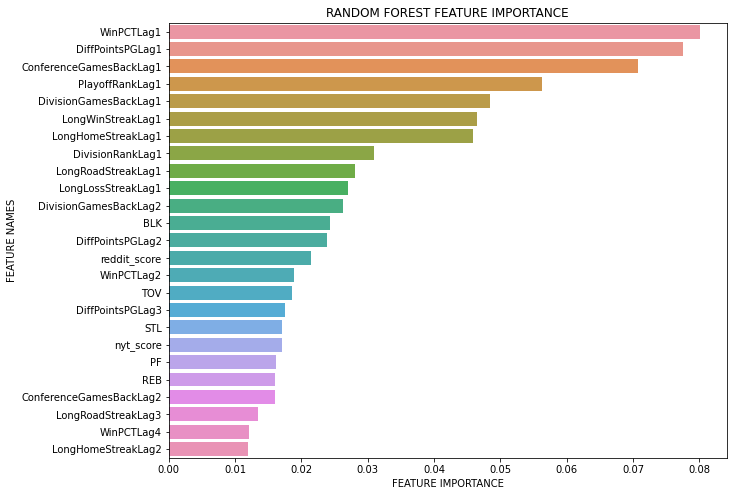

In [44]:
# Random Forest
rf_importance = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_), 
                                   columns=['Feature', 'Importance'])
rf_importance = rf_importance.sort_values('Importance', ascending=False)
rf_importance_top20 = rf_importance.iloc[:25,:]

plt.figure(figsize=(10,8))
sns.barplot(x=rf_importance_top20['Importance'], y=rf_importance_top20['Feature'])
plt.title('RANDOM FOREST FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

## Feature Selection

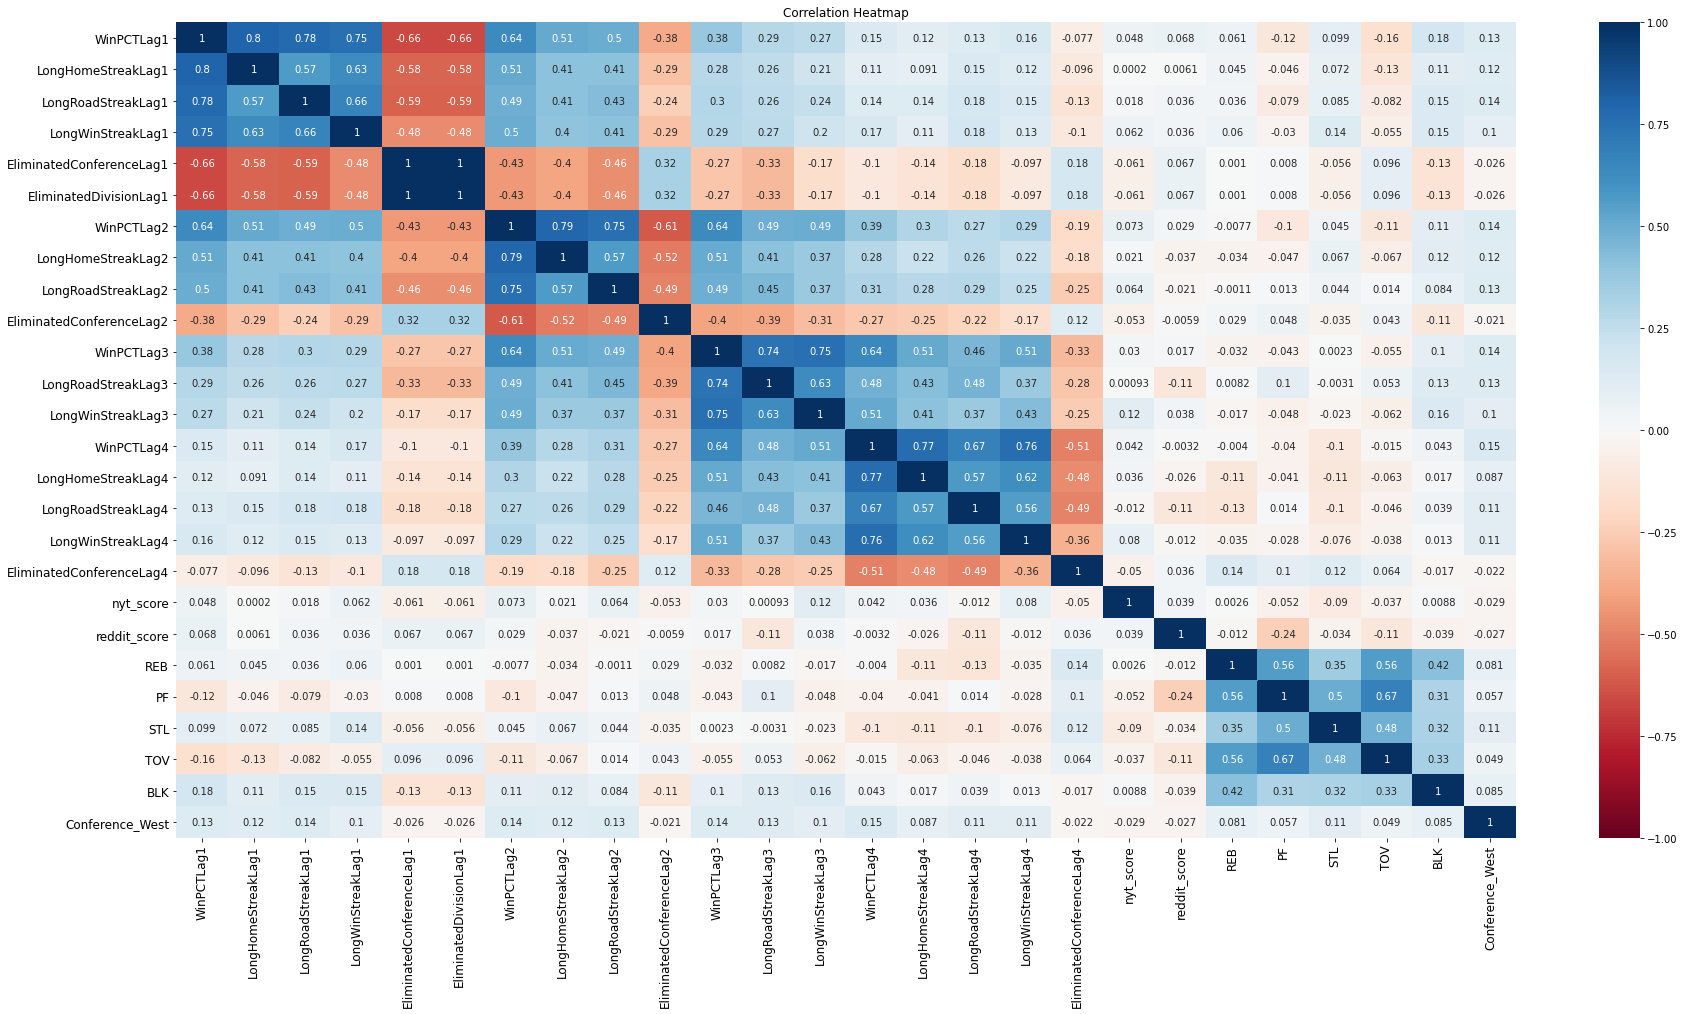

In [100]:
plt.figure(figsize = (30,15))
s = sns.heatmap(X_train_sub.corr(),
             annot = True,
             cmap = 'RdBu',
             vmin = -1,
             vmax= 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

In [94]:
# Find features that are in the bottom 40 of all trees
adaboost_importance_bottom40 = adaboost_importance.iloc[27:,:]['Feature']
xgb_importance_bottom40 = xgb_importance.iloc[27:,:]['Feature']
rf_importance_bottom40 = rf_importance.iloc[27:,:]['Feature']
set(adaboost_importance_bottom40)&set(xgb_importance_bottom40)&set(rf_importance_bottom40)

{'AST',
 'ClinchedConferenceTitleLag1',
 'ClinchedConferenceTitleLag2',
 'ClinchedConferenceTitleLag3',
 'ClinchedConferenceTitleLag4',
 'ClinchedDivisionTitleLag1',
 'ClinchedDivisionTitleLag2',
 'ClinchedDivisionTitleLag3',
 'ClinchedDivisionTitleLag4',
 'ConferenceGamesBackLag3',
 'Conference_East',
 'Conference_West',
 'DivisionGamesBackLag3',
 'DivisionGamesBackLag4',
 'DivisionRankLag3',
 'EliminatedConferenceLag3',
 'EliminatedDivisionLag2',
 'EliminatedDivisionLag3',
 'EliminatedDivisionLag4',
 'LongHomeStreakLag3',
 'LongLossStreakLag2',
 'LongLossStreakLag3',
 'LongWinStreakLag2',
 'PlayoffRankLag2',
 'twitter_score'}

In [95]:
X_train_sub = X_train.drop(['PlayoffRankLag1','PlayoffRankLag2','PlayoffRankLag3','PlayoffRankLag4',
                           'DiffPointsPGLag1','DiffPointsPGLag2','DiffPointsPGLag3','DiffPointsPGLag4',
                           'ConferenceGamesBackLag1','ConferenceGamesBackLag2','ConferenceGamesBackLag3',
                           'ConferenceGamesBackLag4',
                           'DivisionGamesBackLag1','DivisionGamesBackLag2','DivisionGamesBackLag3',
                           'DivisionGamesBackLag4',
                           'Conference_East',
                           'DivisionRankLag1','DivisionRankLag2','DivisionRankLag3','DivisionRankLag4',
                           'LongLossStreakLag1','LongLossStreakLag2','LongLossStreakLag3','LongLossStreakLag4',
                           'AST','ClinchedConferenceTitleLag1','ClinchedConferenceTitleLag2',
                            'ClinchedConferenceTitleLag3','ClinchedConferenceTitleLag4',
                            'ClinchedDivisionTitleLag1','ClinchedDivisionTitleLag2','ClinchedDivisionTitleLag3',
                            'ClinchedDivisionTitleLag4',
                            'ConferenceGamesBackLag3','DivisionGamesBackLag3','DivisionGamesBackLag4',
                            'EliminatedConferenceLag3',
                            'EliminatedDivisionLag2','EliminatedDivisionLag3','EliminatedDivisionLag4',
                            'LongHomeStreakLag3','LongLossStreakLag2','LongLossStreakLag3','LongWinStreakLag2',
                            'twitter_score'],
                           axis=1)

X_val_sub = X_val.drop(['PlayoffRankLag1','PlayoffRankLag2','PlayoffRankLag3','PlayoffRankLag4',
                           'DiffPointsPGLag1','DiffPointsPGLag2','DiffPointsPGLag3','DiffPointsPGLag4',
                           'ConferenceGamesBackLag1','ConferenceGamesBackLag2','ConferenceGamesBackLag3',
                           'ConferenceGamesBackLag4',
                           'DivisionGamesBackLag1','DivisionGamesBackLag2','DivisionGamesBackLag3',
                           'DivisionGamesBackLag4',
                           'Conference_East',
                           'DivisionRankLag1','DivisionRankLag2','DivisionRankLag3','DivisionRankLag4',
                           'LongLossStreakLag1','LongLossStreakLag2','LongLossStreakLag3','LongLossStreakLag4',
                           'AST','ClinchedConferenceTitleLag1','ClinchedConferenceTitleLag2',
                            'ClinchedConferenceTitleLag3','ClinchedConferenceTitleLag4',
                            'ClinchedDivisionTitleLag1','ClinchedDivisionTitleLag2','ClinchedDivisionTitleLag3',
                            'ClinchedDivisionTitleLag4',
                            'ConferenceGamesBackLag3','DivisionGamesBackLag3','DivisionGamesBackLag4',
                            'EliminatedConferenceLag3',
                            'EliminatedDivisionLag2','EliminatedDivisionLag3','EliminatedDivisionLag4',
                            'LongHomeStreakLag3','LongLossStreakLag2','LongLossStreakLag3','LongWinStreakLag2',
                            'twitter_score'],
                           axis=1)

X_test_sub = X_val.drop(['PlayoffRankLag1','PlayoffRankLag2','PlayoffRankLag3','PlayoffRankLag4',
                           'DiffPointsPGLag1','DiffPointsPGLag2','DiffPointsPGLag3','DiffPointsPGLag4',
                           'ConferenceGamesBackLag1','ConferenceGamesBackLag2','ConferenceGamesBackLag3',
                           'ConferenceGamesBackLag4',
                           'DivisionGamesBackLag1','DivisionGamesBackLag2','DivisionGamesBackLag3',
                           'DivisionGamesBackLag4',
                           'Conference_East',
                           'DivisionRankLag1','DivisionRankLag2','DivisionRankLag3','DivisionRankLag4',
                           'LongLossStreakLag1','LongLossStreakLag2','LongLossStreakLag3','LongLossStreakLag4',
                           'AST','ClinchedConferenceTitleLag1','ClinchedConferenceTitleLag2',
                            'ClinchedConferenceTitleLag3','ClinchedConferenceTitleLag4',
                            'ClinchedDivisionTitleLag1','ClinchedDivisionTitleLag2','ClinchedDivisionTitleLag3',
                            'ClinchedDivisionTitleLag4',
                            'ConferenceGamesBackLag3','DivisionGamesBackLag3','DivisionGamesBackLag4',
                            'EliminatedConferenceLag3',
                            'EliminatedDivisionLag2','EliminatedDivisionLag3','EliminatedDivisionLag4',
                            'LongHomeStreakLag3','LongLossStreakLag2','LongLossStreakLag3','LongWinStreakLag2',
                            'twitter_score'],
                           axis=1)

# Building Models (Round 2: After Feature Selection)

## Logistic Regression

In [84]:
# Hyperparameter tuning
logreg_param = {'penalty': ['l1','l2'], 'C': loguniform(1e-5, 100), 
                'max_iter': np.arange(2000,5000,300), 'solver': ['liblinear','saga']}

# Build the model
logreg = LogisticRegression()
logreg_gridsearch = RandomizedSearchCV(logreg, logreg_param, n_iter = 150, cv = time_series_split, 
                                       random_state=42,scoring = scoring, refit = 'f1',n_jobs = -1)
logreg_gridsearch.fit(X_train_sub, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', logreg_gridsearch.best_params_)

Best hyperparameters: {'C': 0.0067851099536515485, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}


In [85]:
# Fit to validation set data
best_logreg = logreg_gridsearch.best_estimator_
logreg_pred = best_logreg.predict(X_val_sub)
logreg_probs = best_logreg.predict_proba(X_val_sub)[:,1]

logreg_f1, logreg_accuracy = f1_score(y_val,logreg_pred), accuracy_score(y_val,logreg_pred)
logreg_recall, logreg_precision = recall_score(y_val,logreg_pred), precision_score(y_val,logreg_pred)
logreg_auc = roc_auc_score(y_val,logreg_probs)

logreg_metrics = pd.DataFrame([logreg_f1, logreg_accuracy, logreg_recall, logreg_precision, logreg_auc], 
                              index = metrics)
logreg_metrics

,0
f1-score,0.666667
Accuracy,0.600000
Recall,0.750000
Precision,0.600000
ROC-AUC,0.727679


## Support Vector Machine

In [86]:
# Hyperparameter tuning
svc_param = {'C': loguniform(1e-3, 1e2), 'gamma': np.arange(0.0001,0.1,0.04), 
             'kernel': ['linear', 'rbf'], 'probability': [True]}

# Build the model
svc = SVC()
svc_gridsearch = RandomizedSearchCV(svc, svc_param, n_iter = 150, cv = time_series_split, 
                                    random_state=42,scoring = scoring, refit = 'f1',n_jobs = -1)
svc_gridsearch.fit(X_train_sub, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', svc_gridsearch.best_params_)

Best hyperparameters: {'C': 2.898545782591001, 'gamma': 0.040100000000000004, 'kernel': 'rbf', 'probability': True}


In [87]:
# Fit to validation set data
best_svc = svc_gridsearch.best_estimator_
svc_pred = best_svc.predict(X_val_sub)
svc_probs = best_svc.predict_proba(X_val_sub)[:,1]

svc_f1, svc_accuracy = f1_score(y_val,svc_pred), accuracy_score(y_val,svc_pred)
svc_recall, svc_precision = recall_score(y_val,svc_pred), precision_score(y_val,svc_pred)
svc_auc = roc_auc_score(y_val,svc_probs)

svc_metrics = pd.DataFrame([svc_f1, svc_accuracy, svc_recall, svc_precision, svc_auc], 
                              index = metrics)
svc_metrics

,0
f1-score,0.742857
Accuracy,0.700000
Recall,0.812500
Precision,0.684211
ROC-AUC,0.723214


# Naive Bayes

In [88]:
# We use Gaussian Naive Bayes because of the nature of our features being mostly continuous

# Hyperparameter tuning
gnb_param = {'var_smoothing': loguniform(1e-10, 1e-3)}

# Build the model
gnb = GaussianNB()
gnb_gridsearch = RandomizedSearchCV(gnb, gnb_param, n_iter = 150, cv = time_series_split, random_state=42, 
                                    scoring = scoring,refit = 'f1', n_jobs = -1)
gnb_gridsearch.fit(X_train_sub, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', gnb_gridsearch.best_params_)

Best hyperparameters: {'var_smoothing': 4.185822729546973e-08}


In [89]:
# Fit to validation set data
best_gnb = gnb_gridsearch.best_estimator_
gnb_pred = best_gnb.predict(X_val_sub)
gnb_probs = best_gnb.predict_proba(X_val_sub)[:,1]

gnb_f1, gnb_accuracy = f1_score(y_val,gnb_pred), accuracy_score(y_val,gnb_pred)
gnb_recall, gnb_precision = recall_score(y_val,gnb_pred), precision_score(y_val,gnb_pred)
gnb_auc = roc_auc_score(y_val,gnb_probs)

gnb_metrics = pd.DataFrame([gnb_f1, gnb_accuracy, gnb_recall, gnb_precision, 
                                 gnb_auc], index = metrics)
gnb_metrics

,0
f1-score,0.764706
Accuracy,0.733333
Recall,0.812500
Precision,0.722222
ROC-AUC,0.727679


# Neural Networks

In [90]:
# Hyperparameter tuning
mlp_param = {'hidden_layer_sizes': [(10,), (50,), (100,), (10,10), (50,50), (100,100)],
             'activation': ['relu', 'logistic', 'tanh'], 'solver': ['adam', 'lbfgs', 'sgd'],
             'alpha': loguniform(1e-3, 1e0),'learning_rate': ['constant', 'adaptive']
}

# Build the model
mlp = MLPClassifier(max_iter = 10000)
mlp_gridsearch = RandomizedSearchCV(mlp, mlp_param, n_iter = 150, cv = time_series_split, random_state=42, 
                                    scoring = scoring,refit = 'f1', n_jobs = -1)
mlp_gridsearch.fit(X_train_sub, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', mlp_gridsearch.best_params_)

Best hyperparameters: {'activation': 'relu', 'alpha': 0.006907016945696069, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [91]:
# Fit to validation set data
best_mlp = mlp_gridsearch.best_estimator_
mlp_pred = best_mlp.predict(X_val_sub)
mlp_probs = best_mlp.predict_proba(X_val_sub)[:,1]

mlp_f1, mlp_accuracy = f1_score(y_val,mlp_pred), accuracy_score(y_val,mlp_pred)
mlp_recall, mlp_precision = recall_score(y_val,mlp_pred), precision_score(y_val,mlp_pred)
mlp_auc = roc_auc_score(y_val,mlp_probs)

mlp_metrics = pd.DataFrame([mlp_f1, mlp_accuracy, mlp_recall, mlp_precision, 
                                 mlp_auc], index = metrics)
mlp_metrics

,0
f1-score,0.742857
Accuracy,0.700000
Recall,0.812500
Precision,0.684211
ROC-AUC,0.651786


## Summary of Models' Performance

In [92]:
combined_metrics = pd.concat([adaboost_metrics, xgb_metrics,rf_metrics, logreg_metrics, svc_metrics,gnb_metrics,
                              mlp_metrics], axis = 1)
combined_metrics.columns = ['AdaBoost','Extreme Gradient Boosting','Random Forest','Logistic Regression',
                            'Support Vector Machine', 'Gaussian Naive Bayes','Multi-layer Perceptron classifier']
combined_metrics

,AdaBoost,Extreme Gradient Boosting,Random Forest,Logistic Regression,Support Vector Machine,Gaussian Naive Bayes,Multi-layer Perceptron classifier
f1-score,0.702703,0.722222,0.647059,0.666667,0.742857,0.764706,0.742857
Accuracy,0.633333,0.666667,0.600000,0.600000,0.700000,0.733333,0.700000
Recall,0.812500,0.812500,0.687500,0.750000,0.812500,0.812500,0.812500
Precision,0.619048,0.650000,0.611111,0.600000,0.684211,0.722222,0.684211
ROC-AUC,0.732143,0.705357,0.705357,0.727679,0.723214,0.727679,0.651786


# Using the Chosen Model on the Test Set

In [112]:
# Get the other metrics for the best model

# Since only 16 teams can make it into the playoffs, we take the top 16 teams using the predict probability 
# function, there must also be 8 teams from each region

# Get probabilities of making it to the Playoffs from the best hyperparameters
y_probs = best_svc.predict_proba(X_test_sub)[:,1]

# Combine the probabilities with the initial full dataframe
test_data = test_data.reset_index().drop('index',axis = 1)
combined = pd.concat([test_data,pd.DataFrame(y_probs,columns = ['prob'])],axis = 1)

# Input class labels for each team in each season based on the ranking of probabilties. The top 8 teams for each
# season and each region will be labelled as 1 while the others will be labelled as 0

classone = combined.sort_values('prob',ascending=False).groupby(['SeasonID','Conference']).head(8)
combined['predicted_class'] = 0
combined.loc[classone.index, 'predicted_class'] = 1
y_pred = combined['predicted_class']

f1, accuracy = f1_score(y_test,y_pred), accuracy_score(y_test,y_pred)
recall, precision = recall_score(y_test,y_pred), precision_score(y_test,y_pred)
auc = roc_auc_score(y_test,y_probs)

metrics_name = ['f1-score','Accuracy','Recall','Precision','ROC-AUC']

final_metrics = pd.DataFrame([f1, accuracy, recall, precision, auc],index = metrics_name)
final_metrics

,0
f1-score,0.750000
Accuracy,0.733333
Recall,0.750000
Precision,0.750000
ROC-AUC,0.723214
